In [1]:
using Revise
using PyPlot
using Infiltrator
using LinearAlgebra
using Bem2d
using PyCall
using FEniCS

In [156]:
include("Helpers.jl")

twopanel (generic function with 2 methods)

In [2]:
mu = 30e9
lambda = 30e9
eta = 1e19 # just made up a number!
nu = 0.25
g = 9.81
rho = 2700
siay = 3600 * 24 * 365.2425

3.1556952e7

In [8]:
# Element geometries and data structures 
elsbox = Elements(Int(1e5))

# Box geometry
B = -50e3 # Bottom
R = 20e3 # Right
T = 0e3 # Top
L = -20e3; # Left
VE_z = -20e3 # Depth below which we use a Maxwell rheology
nside = 50 # number of elements per box side

addelsez!(elsbox, discretizedline(L, B, R, B, nside)..., "B")
addelsez!(elsbox, discretizedline(R, B, R, T, nside)..., "R")
addelsez!(elsbox, discretizedline(R, T, L, T, nside)..., "T")
addelsez!(elsbox, discretizedline(L, T, L, B, nside)..., "L")

# Fault geometry
nfault = 1
x1, y1, x2, y2 = discretizedline(-10e3, -10e3, -5e3, -5e3, nfault) # 45 degree dipping fault
addelsez!(elsbox, x1, y1, x2, y2, "F")

idx = getidxdict(elsbox);
BRTL_idx = [idx["B"] ; idx["R"] ; idx["T"] ; idx["L"]]
RTL_idx = [idx["R"] ; idx["T"] ; idx["L"]];

getidx found 50 elements with label "B"
getidx found 50 elements with label "R"
getidx found 50 elements with label "T"
getidx found 50 elements with label "L"
getidx found 1 elements with label "F"


In [145]:
npts = 50
offset = 1
xgrid, ygrid = obsgrid(L+offset, B+offset, R-offset, T-offset, npts);

In [146]:
### Slip from fault only
T_TB_F, H_TB_F = PUTC(slip2dispstress, elsbox, BRTL_idx, idx["F"], mu, nu)
Fslip = [100; 100]; # y-direction slip only
Uslip = T_TB_F * Fslip
Tslip = H_TB_F * Fslip;

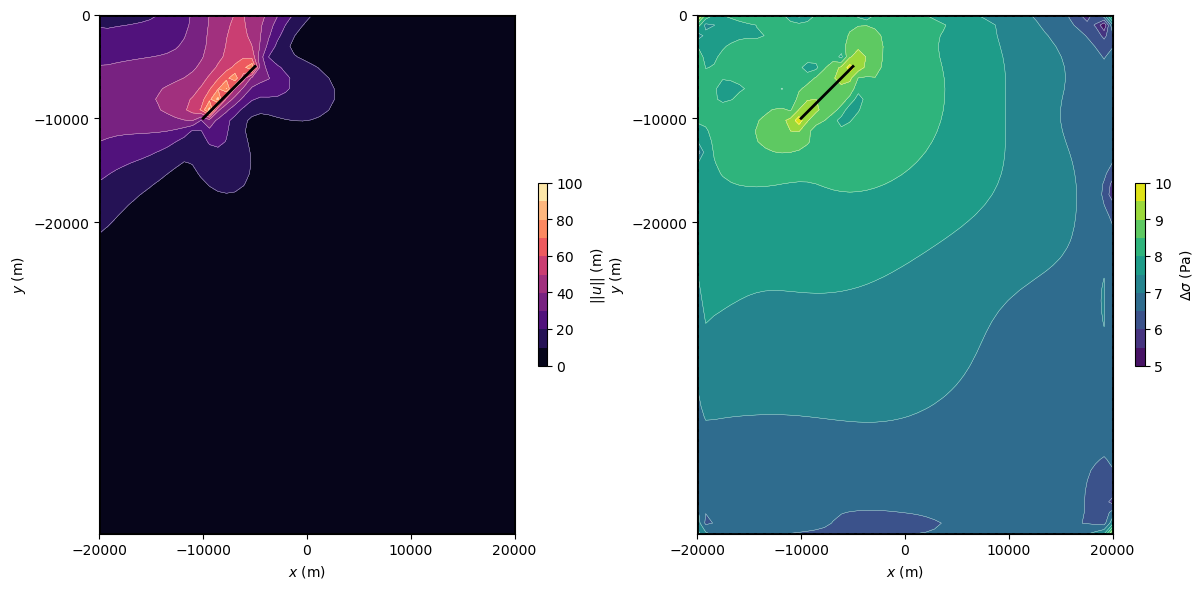

In [157]:
# Kernels and solve
T_B_BRTL, H_B_BRTL = PUTC(slip2dispstress, elsbox, idx["B"], BRTL_idx, mu, nu)
T_RTL_BRTL, H_RTL_BRTL = PUTC(slip2dispstress, elsbox, RTL_idx, BRTL_idx, mu, nu)
bcsbox = zeros(8 * nside)
bcsbox[1:2*nside] = -Uslip[1:2*nside] # Bottom
bcsbox[2*nside+1:4*nside] = -Tslip[2*nside+1:4*nside] # Right
bcsbox[4*nside+1:6*nside] = -Tslip[4*nside+1:6*nside] # Top
bcsbox[6*nside+1:8*nside] = -Tslip[6*nside+1:8*nside] # Left
THbox = [T_B_BRTL ; H_RTL_BRTL]
Ueffbox = THbox \ bcsbox

# Volume evaluation
UTB, STB = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, BRTL_idx,
                           Ueffbox[1:2:end], Ueffbox[2:2:end], mu, nu)
UF, SF = constdispstress(slip2dispstress, xgrid, ygrid, elsbox, idx["F"],
                         Fslip[1:2:end], Fslip[2:2:end], mu, nu)
Ufaultonly = UTB .+ UF
Sfaultonly = STB .+ SF
twopanel(xgrid, ygrid, npts, Ufaultonly, Sfaultonly, idx, elsbox, figsize=(12,6), ylim=[B,T]);

## TODO LIST

* ~~Step function in eta~~
* ~~Calculate dVdt via stress/stress deviator~~
* ~~Need to somehow collect the dof interpolation points and provide values at those points.~~
* ~~Calculate stress given a BEM solution.~~ 
* ~~Expand BEM box solution domain. Or just expand the twopanel figure plotting domain?~~


In [9]:
fenics_mesh = RectangleMesh(Point((L - 5000, T + 5000)), Point((R + 5000, B - 5000)), 100, 100)
scalar_fs = FunctionSpace(fenics_mesh, "P", 1)
vector_fs = VectorFunctionSpace(fenics_mesh, "P", 2) # TODO: can i make this order = 1?
tensor_fs = FunctionSpace(FEniCS.fenics.TensorFunctionSpace(fenics_mesh.pyobject, "P", 1))

f = Constant((0, -rho * g)) # Vector of uniform body force
fenics_u = fenics_solve(vector_fs, f);

Solving linear variational problem.


"FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), TensorElement(FiniteElement('Lagrange', triangle, 1), shape=(2, 2), symmetry={}))"

In [127]:
tensor_xs = reshape(py"lambda x: x.tabulate_dof_coordinates()"(tensor_fs.pyobject), (4,:,2))
xs = tensor_xs[1,:,:]

10201×2 Array{Float64,2}:
 -25000.0    5000.0
 -25000.0    4400.0
 -24500.0    5000.0
 -25000.0    3800.0
 -24500.0    4400.0
 -24000.0    5000.0
 -25000.0    3200.0
 -24500.0    3800.0
 -24000.0    4400.0
 -23500.0    5000.0
 -25000.0    2600.0
 -24500.0    3200.0
 -24000.0    3800.0
      ⋮            
  24500.0  -53200.0
  25000.0  -52600.0
  23500.0  -55000.0
  24000.0  -54400.0
  24500.0  -53800.0
  25000.0  -53200.0
  24000.0  -55000.0
  24500.0  -54400.0
  25000.0  -53800.0
  24500.0  -55000.0
  25000.0  -54400.0
  25000.0  -55000.0

In [111]:
x_dofs = py"lambda x: x.tabulate_dof_coordinates()"(scalar_fs.pyobject);
sq_sep = (x_dofs .- [0.0, 0.0]') .^ 2;
dist = broadcast(sqrt, dropdims(sum(sq_sep, dims=2),dims=2))

myf = FeFunction(scalar_fs)
vals = py"lambda x, vs: x.vector().set_local(vs)"(myf.pyobject, dist)
println(py"lambda x: x.vector().get_local()"(myf.pyobject)[1], " ", dist[1])

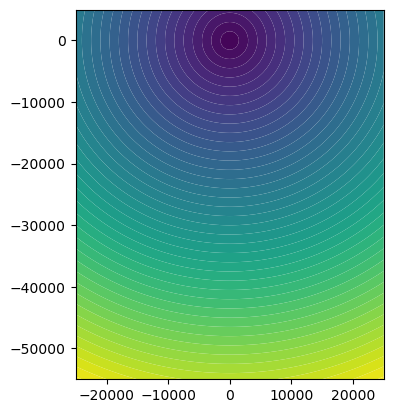

PyObject <matplotlib.tri.tricontour.TriContourSet object at 0x7f26cc9df850>

In [100]:
FEniCS.Plot(myf)

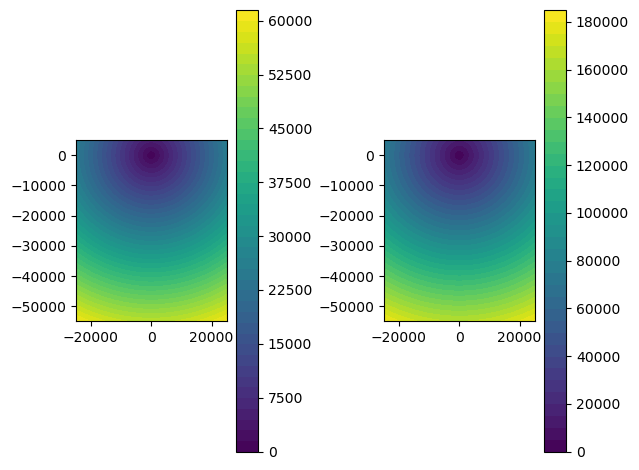

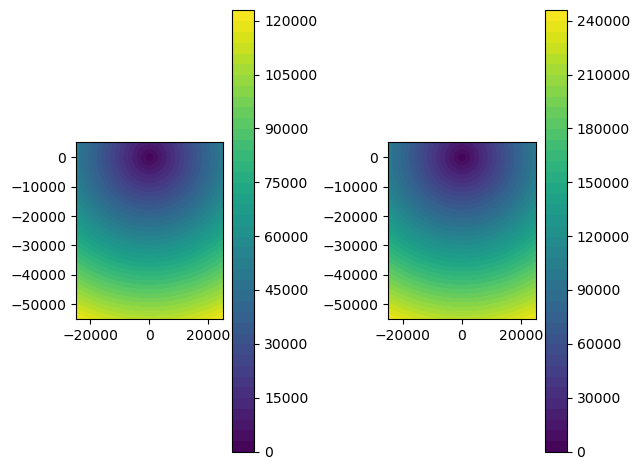

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


In [141]:
myf2 = FeFunction(tensor_fs)
dist_repeat = repeat(dist', 4, 1)
for i in 1:4
    dist_repeat[i,:] *= i
end
vals = py"lambda x, vs: x.vector().set_local(vs)"(myf2.pyobject, reshape(dist_repeat, (:)))
py"lambda x: x.vector().get_local()"(myf2.pyobject)
fenics_plot_vec2d(FEniCS.dot(myf2, Constant((1.0, 0.0))))
fenics_plot_vec2d(FEniCS.dot(myf2, Constant((0.0, 1.0))))
# Conclusions!
# tensor_xx = index 1
# tensor_yx = index 2
# tensor_xy = index 3
# tensor_yy = index 4

In [142]:
sigma = fenics_stress(fenics_u, lambda, mu)

# no viscous behavior in the surface layer, mu/eta below VE_z
# We can't use a threshold for eta because we divide by eta and dividing by zero is bad.
fenics_mu_over_eta = interpolate(Expression("0.0 + mu/eta*(x[1] <= VE_z)", degree=0, mu=mu, eta=eta, VE_z=VE_z), scalar_fs)

# https://en.wikipedia.org/wiki/Cauchy_stress_tensor#Stress_deviator_tensor
stress_deviator = sigma - (1.0/3)*FEniCS.tr(sigma)*Identity(2);

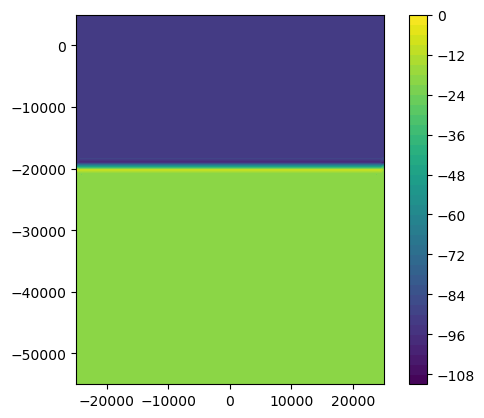

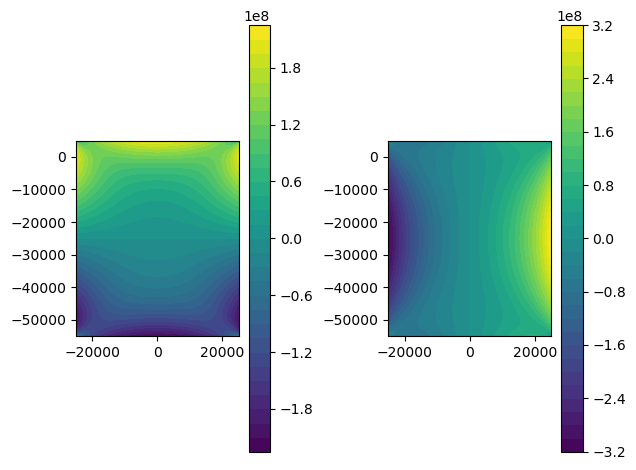

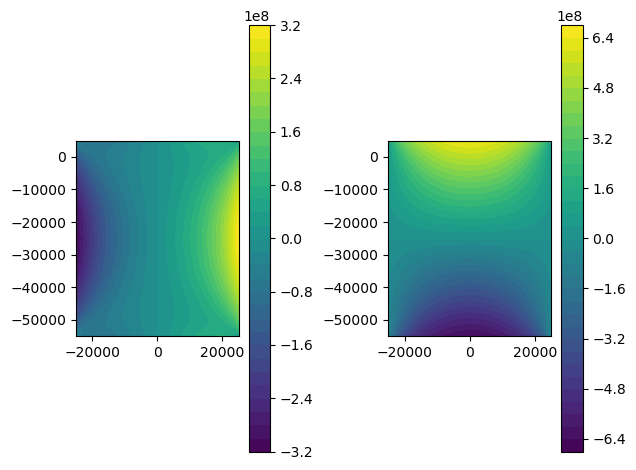

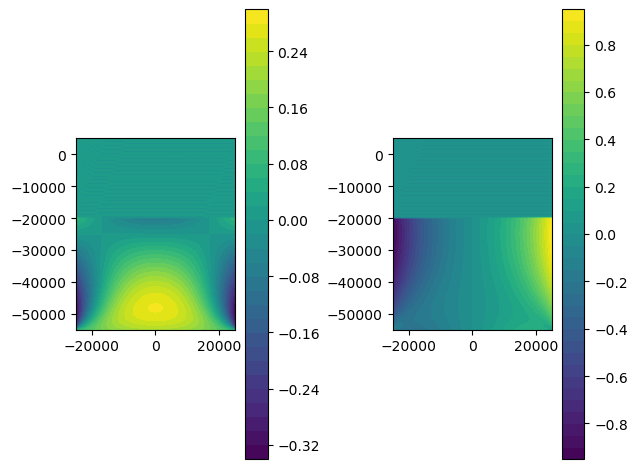

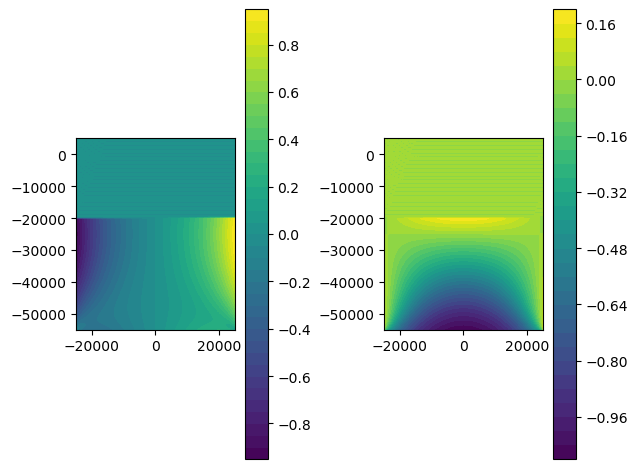

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


In [143]:
#FEniCS.get_array(project(FEniCS.dot(fenics_mu_over_eta * stress_deviator, Constant((1.0,0.0))), V))
fenics_plot_scalar(project(log(fenics_mu_over_eta + 1e-40), FunctionSpace(fenics_mesh, "P", 1)))
fenics_plot_vec2d(project(FEniCS.dot(sigma, Constant((1.0,0.0))), V))
fenics_plot_vec2d(project(FEniCS.dot(sigma, Constant((0.0,1.0))), V))
fenics_plot_vec2d(project(FEniCS.dot(fenics_mu_over_eta * stress_deviator, Constant((1.0,0.0))), V))
fenics_plot_vec2d(project(FEniCS.dot(fenics_mu_over_eta * stress_deviator, Constant((0.0,1.0))), V))

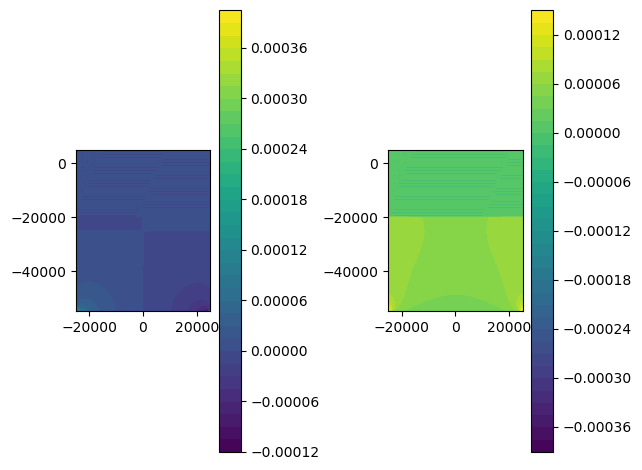

          Calling FFC just-in-time (JIT) compiler, this may take some time.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


In [79]:
dVdt = project(fenics_mu_over_eta * div(stress_deviator), V)
fenics_plot_vec2d(dVdt)

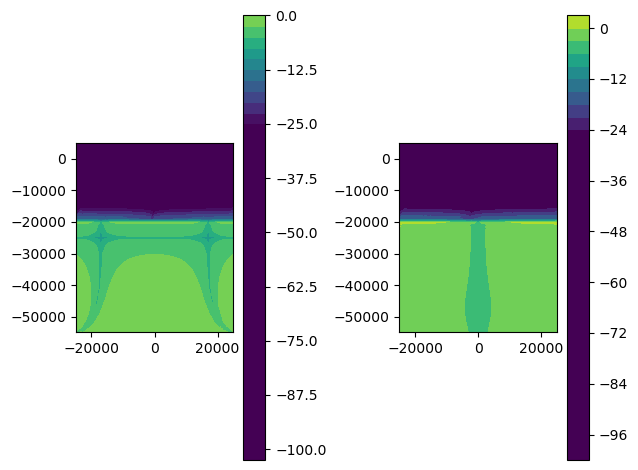

Object cannot be plotted directly, projecting to piecewise linears.
ln(|((f_2205) . (f_2214))|) ln(|((f_2205) . (f_2215))|)
          Calling FFC just-in-time (JIT) compiler, this may take some time.
Object cannot be plotted directly, projecting to piecewise linears.


In [85]:
f = siay * dVdt
py"""
from fenics import *
def FF(f):
    import matplotlib.pyplot as plt
    fx = ln(abs(dot(f,Constant((1.0, 0.0)))))
    fy = ln(abs(dot(f,Constant((0.0, 1.0)))))
    print(fx, fy)
    plt.figure()
    plt.subplot(1,2,1)
    c = plot(fx, colobar=True, vmin = -25, vmax = 5)
    plt.colorbar(c)
    plt.subplot(1,2,2)
    c = plot(fy, colobar=True, vmin = -25, vmax = 5)
    plt.colorbar(c)
    plt.tight_layout()
    plt.show()
"""
py"FF"(project(FEniCS.dot(fenics_mu_over_eta * stress_deviator, Constant((1.0,0.0))), V).pyobject)